<h1><img src='https://sprtsiq.com/img/logo/SprtsIQ_Logo.png' width='7%' style='padding-right: 50px'></img>Important Features Analysis</h1>


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from multiprocessing import Pool
from itertools import repeat
from sklearn.model_selection import train_test_split
from utils.data_preprocessing import feature_preprocessor
from utils import plotting

## Important Features

In [56]:
features = [
     'RushingYardsAllowed',
	 'AssistedTackles',
	 'PasserRatingAllowed',
	 'PassingAttempts',
	 'PointsScoredQuarter1',
	 'OffensiveTouchdowns',
	 'RedZoneConversionsAllowed',
	 'RushingYards',
	 'PointsScoredQuarter3',
	 'Giveaways',
	 'PassingTouchdowns',
	 'ThirdDownAttemptsAgainst',
	 'PointSpread',
	 'PC2_ProductOfAllLoadings',
	 'PC5_RushingAttempsXTimePossessionVSTimeDefense',
	 'FavoriteUnderdog',
]
target = 'MoneyLineWinLoss'

## Loading and preprocessing data

In [57]:
# Reading the data
df = pd.read_excel('data/GameStatsTeamVsOpponentRegPostV2_edited.xlsx', engine='openpyxl')
df = df[df.MoneyLineWinLoss != 'Tie']
df = df[df.SeasonType == 1] # NOTE: WHY, drops ~300

# Reseting index df_raw for multiprocessing jobs
df.reset_index(drop=True, inplace=True)

In [58]:
# grouping labels and features in a meaningful way for future use
ls_labels = ['MoneyLineWinLoss','WinLossMargin','SpreadWinLoss','SpreadWinLossMargin','OverUnderResult','OverUnderMargin']
ls_id = ['GameKey']
ls_team_opponent = ['Team', 'Opponent']
ls_date_features = ['Date', 'Season', 'Week', 'RunningWeek']
ls_cat_features = ['GameStatus', 'SeasonType', 'HomeOrAway', 'Stadium', 'PlayingSurface', 'FavoriteUnderdog']
ls_inmatch_features_contin = ['Temperature', 'Humidity', 'WindSpeed']
ls_outmatch_features_contin = list(set(df.columns.tolist()) - set(ls_labels + ls_id + ls_team_opponent + \
                                                                  ls_date_features + ls_cat_features + \
                                                                  ls_inmatch_features_contin))

In [59]:
# numbers of chunks to split for the entire dataset
num_processes = 3 
chunk_size = int(ceil(len(df.Team.unique())/num_processes)) # number of subjects per chunk
ls_chunk = [df.Team.unique()[i:i+chunk_size] for i in range(0, len(df.Team.unique()), chunk_size)]
ls_df_chunk = [df[df.Team.isin(chunk)] for chunk in ls_chunk]

# Multiprocessing the feature preprocessing jobs
# shifts all the records back by 1
# NOTE adds some random polynomial feature combinations and rolling windows, why does it drop several hundred records?
# drops n_rolling records for each team? n_rolling being 12?
num_jobs = 3
pool = Pool(num_jobs)
df_results = pool.starmap(feature_preprocessor, zip(ls_df_chunk, repeat(ls_outmatch_features_contin), repeat(12)))
df_lookback = pd.concat(df_results, axis=0, sort=False)
pool.close()
pool.join()

engineered_features = list(set(df_lookback.columns) ^ set(df.columns))

In [60]:
df_processed = pd.merge(df[['MoneyLineWinLoss'] + ls_cat_features + ls_inmatch_features_contin], 
                   df_lookback[list(ls_outmatch_features_contin) + engineered_features], 
                   how='inner', 
                   left_index=True, 
                   right_index=True)

df_eda = df_processed[features + [target]]

## Univariate Analysis

In [62]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7276 entries, 384 to 7659
Data columns (total 17 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   RushingYardsAllowed                             7276 non-null   float64
 1   AssistedTackles                                 7276 non-null   float64
 2   PasserRatingAllowed                             7276 non-null   float64
 3   PassingAttempts                                 7276 non-null   float64
 4   PointsScoredQuarter1                            7276 non-null   float64
 5   OffensiveTouchdowns                             7276 non-null   float64
 6   RedZoneConversionsAllowed                       7276 non-null   float64
 7   RushingYards                                    7276 non-null   float64
 8   PointsScoredQuarter3                            7276 non-null   float64
 9   Giveaways                              

Data looks clean, no null values

In [63]:
df_eda.describe(include='all')

,RushingYardsAllowed,AssistedTackles,PasserRatingAllowed,PassingAttempts,PointsScoredQuarter1,OffensiveTouchdowns,RedZoneConversionsAllowed,RushingYards,PointsScoredQuarter3,Giveaways,PassingTouchdowns,ThirdDownAttemptsAgainst,PointSpread,PC2_ProductOfAllLoadings,PC5_RushingAttempsXTimePossessionVSTimeDefense,FavoriteUnderdog,MoneyLineWinLoss
count,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7276.000000,7.276000e+03,7276.000000,7276,7276
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Favorite,Loss
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3620,3638
mean,108.005085,14.934442,85.370843,33.819956,3.748007,2.237012,1.598612,108.450110,4.149808,1.349918,1.401251,13.171385,-0.025667,1.185342e+14,27.183898,NaN,NaN
std,21.089887,4.678175,11.568714,4.099395,2.394172,0.699143,0.547157,22.402994,2.472660,0.548363,0.580354,1.013095,4.259832,1.698214e+14,6.285978,NaN,NaN
min,46.500000,1.500000,45.500000,21.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,0.000000,10.000000,-15.750000,0.000000e+00,10.806452,NaN,NaN
25%,93.500000,11.500000,77.585000,31.000000,1.500000,2.000000,1.000000,93.000000,3.000000,1.000000,1.000000,12.500000,-3.250000,2.243628e+13,22.661666,NaN,NaN
50%,106.500000,14.500000,85.455000,34.000000,3.000000,2.000000,1.500000,107.000000,4.500000,1.000000,1.000000,13.000000,0.000000,6.204301e+13,26.471764,NaN,NaN
75%,121.000000,18.000000,92.935000,36.500000,6.500000,3.000000,2.000000,122.000000,7.000000,2.000000,2.000000,14.000000,3.250000,1.448398e+14,30.948320,NaN,NaN


Confused about the PointSpread having decimal values but will check during next meeting.

### RushingYardsAllowed

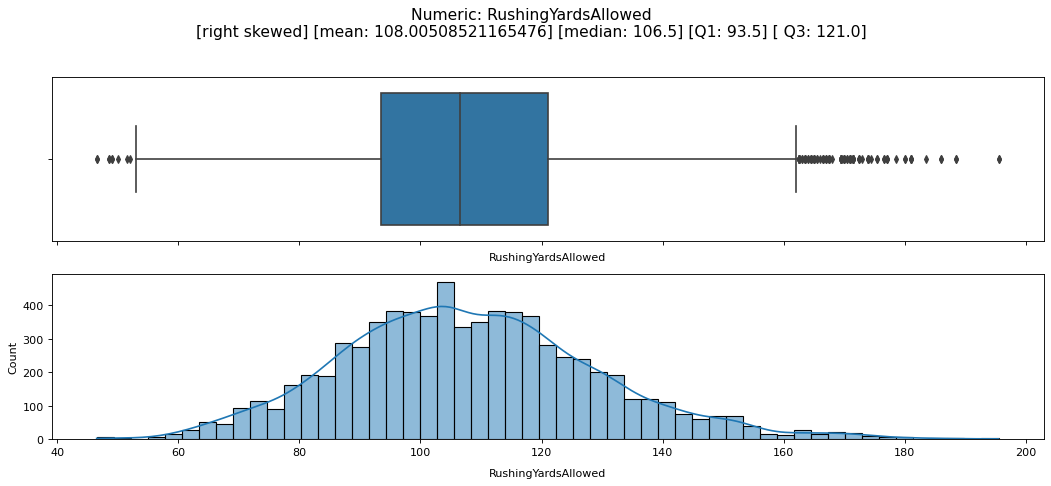

In [64]:
plotting.univariate_numeric(df_eda, 'RushingYardsAllowed')

Fairly normally distributed but somewhat right skewed, easily mended with `np.log`

### AssistedTackles

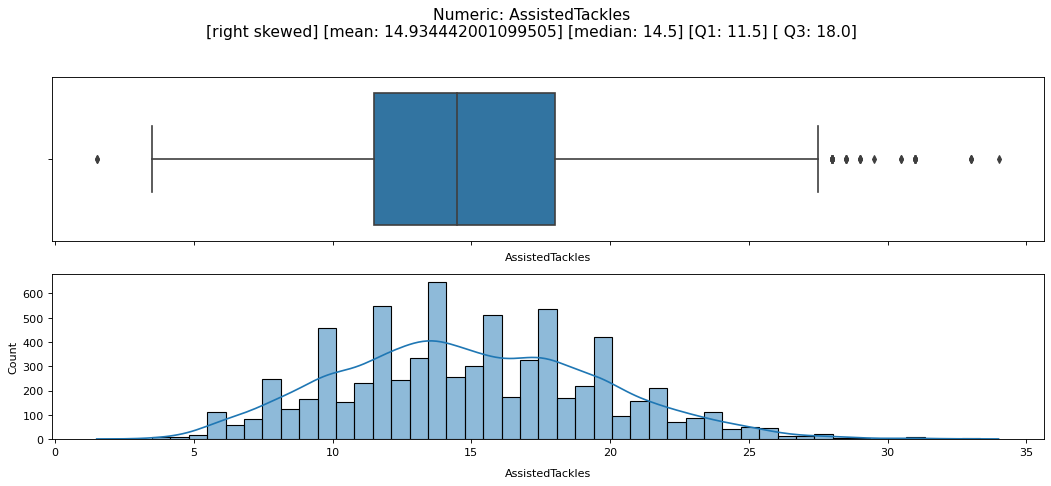

In [66]:
plotting.univariate_numeric(df_eda, 'AssistedTackles')

Fairly normally distributed but somewhat right skewed, easily mended with `np.log`

## PasserRatingAllowed

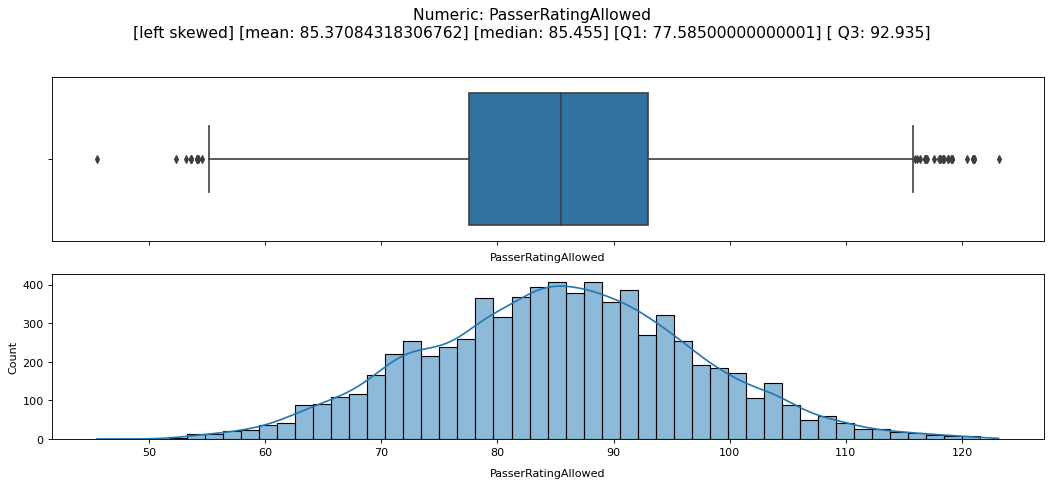

In [68]:
plotting.univariate_numeric(df_eda, 'PasserRatingAllowed')

Fairly normally distributed but somewhat left skewed, easily mended with `np.log`

## PassingAttempts

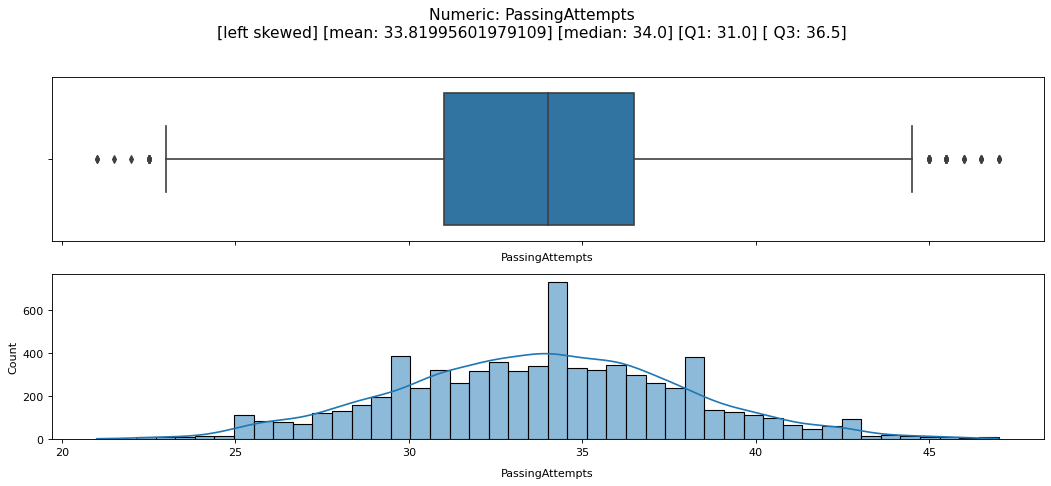

In [70]:
plotting.univariate_numeric(df_eda, 'PassingAttempts')

Fairly normally distributed but somewhat left skewed, easily mended with `np.log`

## PointsScoredQuarter1

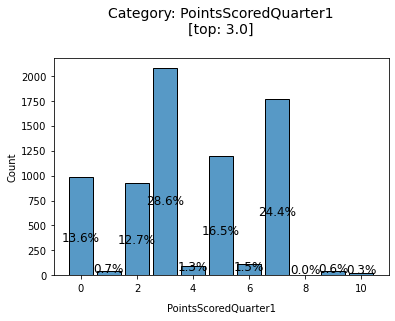

In [72]:
plotting.univariate_categorical(df_eda, 'PointsScoredQuarter1')

Interesting that the PointsScoredQuarter1 maximum appears to only be 10

In [73]:
print('Max of PointsScoredQuarter1:', df_eda['PointsScoredQuarter1'].astype(int).max())

Max of PointsScoredQuarter1: 10


## OffensiveTouchdowns

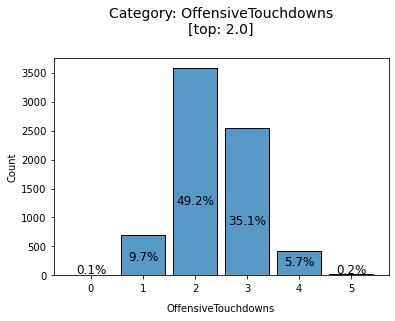

In [74]:
plotting.univariate_categorical(df_eda, 'OffensiveTouchdowns')

NFL teams score 2 to 3 touchdowns in ~84% of their games.

### RedZoneConversionsAllowed

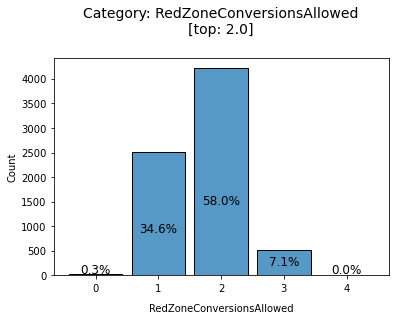

In [75]:
plotting.univariate_categorical(df_eda, 'RedZoneConversionsAllowed')

NFL teams score 1 to 2 red zone conversions in ~92% of their games.

### RushingYards

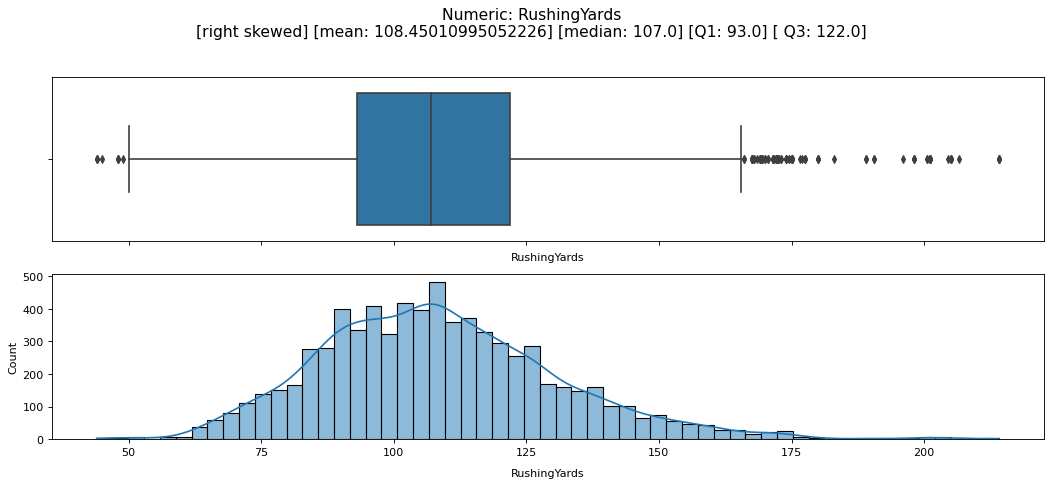

In [76]:
plotting.univariate_numeric(df_eda, 'RushingYards')

Fairly normally distributed but somewhat right skewed, easily mended with `np.log`. Lots of max outliers but I will not remove them.

### PointsScoredQuarter3

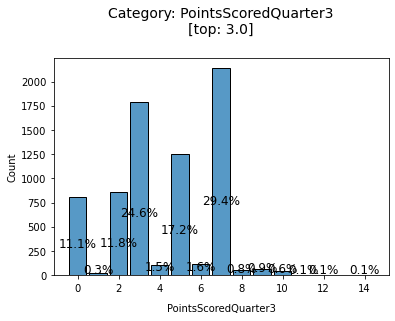

In [78]:
plotting.univariate_categorical(df_eda, 'PointsScoredQuarter3')

In [79]:
print('Likelihood of scoring greater than 7 points in the 3rd quarter:', len(df_eda[df_eda['PointsScoredQuarter3'].astype(int) > 7])/len(df_eda)*100, '%')

Likelihood of scoring greater than 7 points in the 3rd quarter: 2.061572292468389 %


It is extremely rare that more than 7 points are scored in the 3rd quarter

### Giveaways

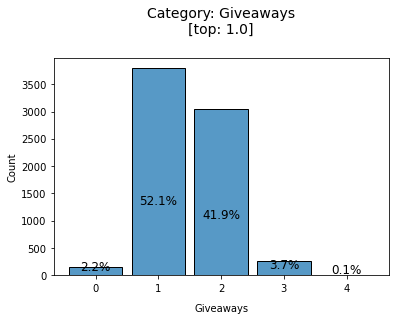

In [80]:
plotting.univariate_categorical(df_eda, 'Giveaways')

There is only a 2.2% likelihood of a team will have a game without a giveaway.

### PassingTouchdowns

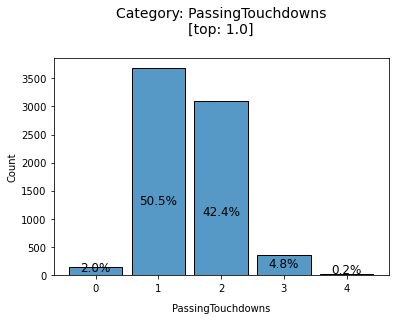

In [81]:
plotting.univariate_categorical(df_eda, 'PassingTouchdowns')

There is only a 2% likelihood of a team will have a game without a PassingTouchdown and only a 5% likelihood a team will have more than 2.

### ThirdDownAttemptsAgainst

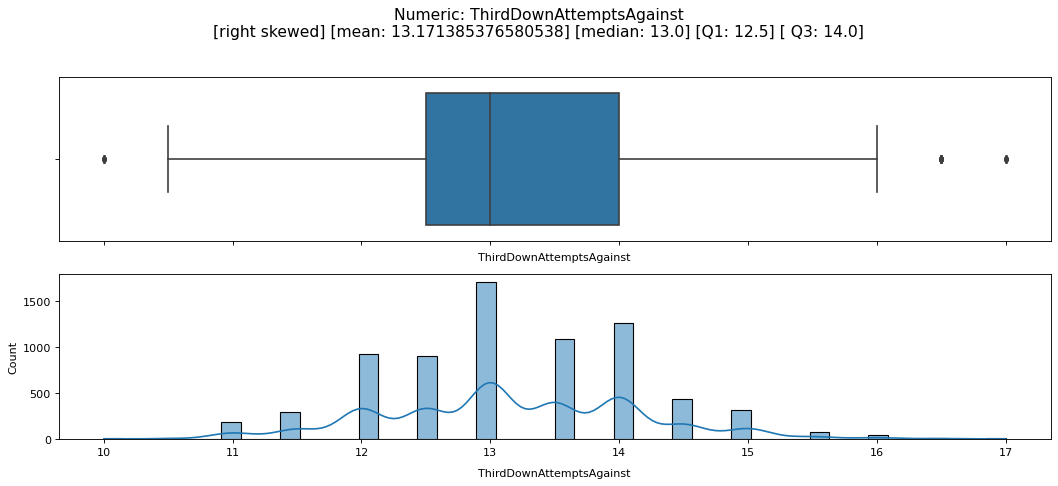

In [82]:
plotting.univariate_numeric(df_eda, 'ThirdDownAttemptsAgainst')

Fairly normally distributed but somewhat right skewed, easily mended with `np.log`.

### PointSpread

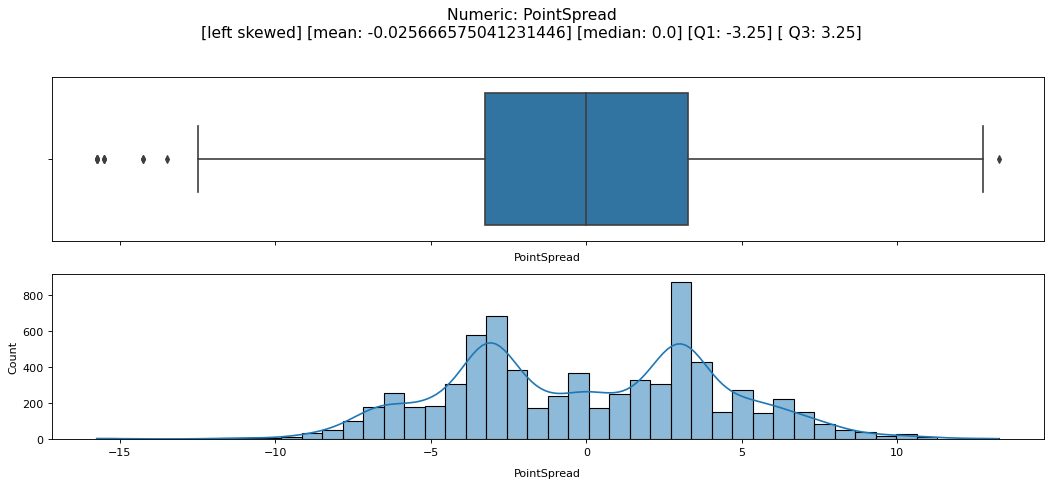

In [84]:
plotting.univariate_numeric(df_eda, 'PointSpread')

Fairly bimodally distributed but barely left skewed. This should not be adjusted.

### PC2_ProductOfAllLoadings

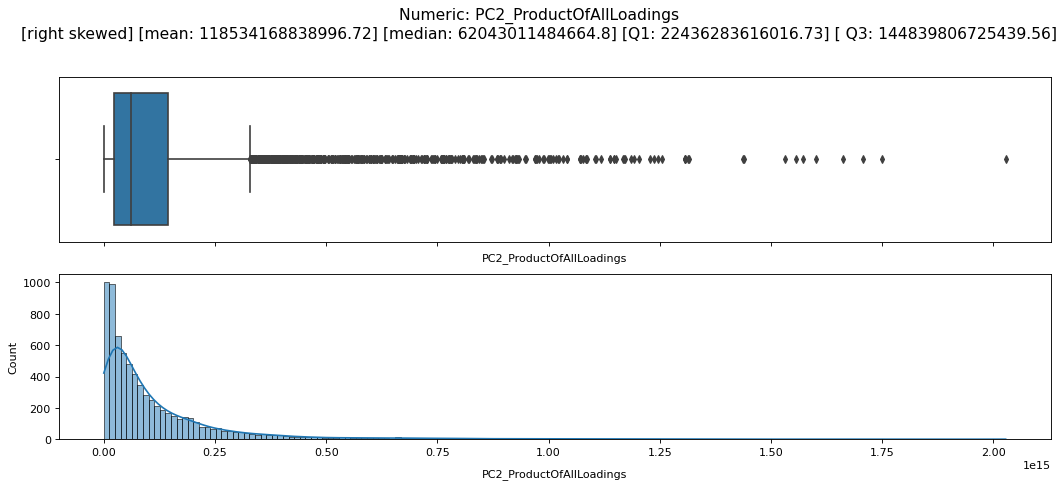

In [85]:
plotting.univariate_numeric(df_eda, 'PC2_ProductOfAllLoadings')

Wildly right skewed, can be adjusted with `np.log`

### PC5_RushingAttempsXTimePossessionVSTimeDefense

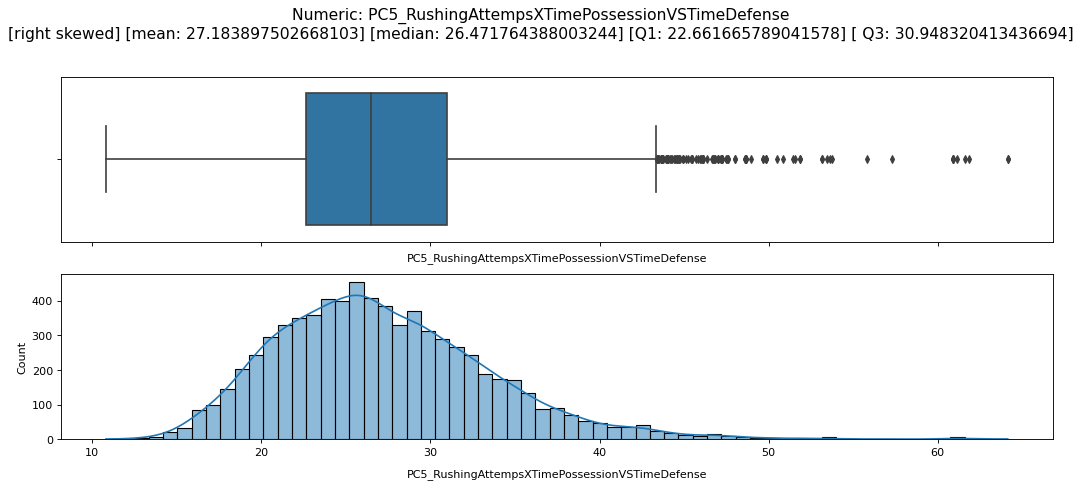

In [87]:
plotting.univariate_numeric(df_eda, 'PC5_RushingAttempsXTimePossessionVSTimeDefense')

Fairly normal but right skewed, can be adjusted with `np.log`

### FavoriteUnderdog

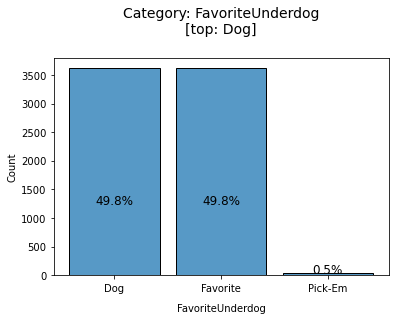

In [89]:
plotting.univariate_categorical(df_eda, 'FavoriteUnderdog')

Only 0.5% of the time is the FavoriteUnderDog 'Pick-Em'. I am tempted to rid the data of this outlier category but will check in next meeting.

### MoneyLineWinLoss (Target Variable)

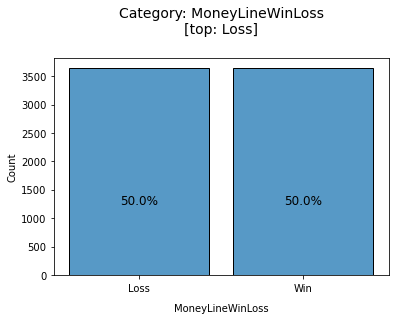

In [90]:
plotting.univariate_categorical(df_eda, 'MoneyLineWinLoss')

Perfectly uniform distribution, this means accuracy can be reliably used as a performance measure.

### Univariate Analysis Summary
- Most continous data is somewhat skewed but fairly normal
- PointSpread has a bimodal distribution which is tricky for linear models
- It is extremely rare FavoriteUnderDog is equal to 'Pick-Em'
- There is only a 2% likelihood of a team will have a game without a PassingTouchdown and only a 5% likelihood a team will have more than 2.
- Interesting that the PointsScoredQuarter1 maximum is only 10
- NFL teams score 2 to 3 touchdowns in ~84% of their games.
- NFL teams score 1 to 2 red zone conversions in ~92% of their games.
- It is extremely rare that more than 7 points are scored in the 3rd quarter.
- There is only a 2.2% likelihood of a team will have a game without a giveaway.

## Bivariate Analysis 

In [91]:
categorical = ['PointsScoredQuarter1', 'OffensiveTouchdowns', 'RedZoneConversionsAllowed', 'PointsScoredQuarter3', 'Giveaways', 'PassingTouchdowns']
df_eda[categorical] = df_eda[categorical].astype(np.int)
df_eda[target] = df_eda[target].apply(lambda x: 1 if x == 'Win' else 0).astype(np.int)

### Features and Target Correlation Matrix
This matrix does not include PC features since they are aggregations of other features

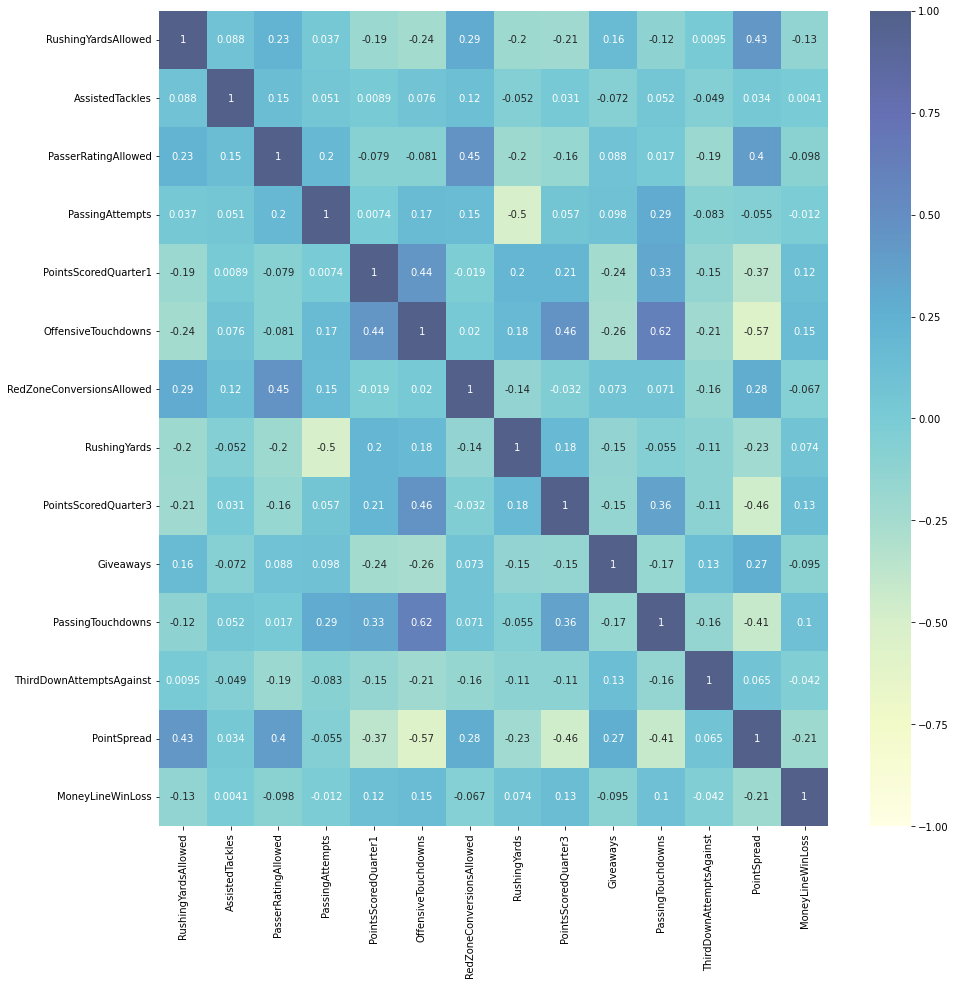

In [101]:
plotting.corr(
    df_eda, 
    *[f for f in features if not f.startswith('PC')],
    target 
)

Unexpected Moderate Correlations
- PointSpread & OffensiveTouchdowns (-0.57)
- PassingTouchdowns & OffensiveTouchdowns (0.62)

No features had a meaningful correlation with the target variable MoneyLineWinLoss

### FavoriteUnderdog & MoneyLineWinLoss

In [121]:
df_eda.groupby('FavoriteUnderdog')['MoneyLineWinLoss'].value_counts().to_frame()

MoneyLineWinLoss
FavoriteUnderdog MoneyLineWinLoss                  
Dog              0                             2410
                 1                             1210
Favorite         1                             2410
                 0                             1210
Pick-Em          0                               18
                 1                               18

It appears the categories are evenly distributed, likely by design.

### PC2_ProductOfAllLoadings & MoneyLineWinLoss

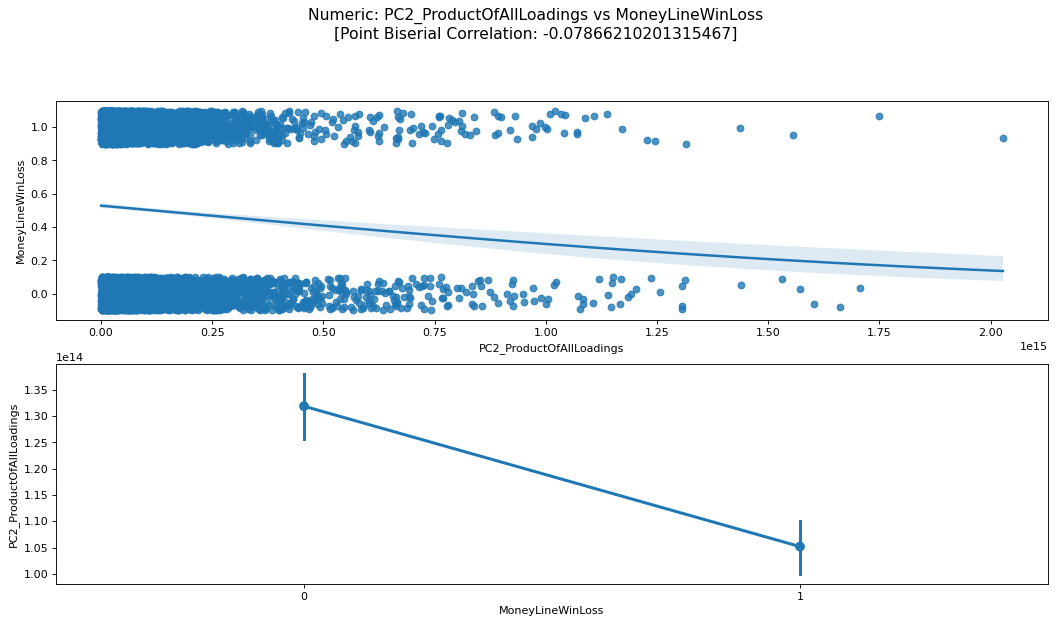

In [111]:
plotting.numeric_binary_bivariate(df_eda, 'PC2_ProductOfAllLoadings', 'MoneyLineWinLoss')

Miniscule negative correlation, not menaingful.

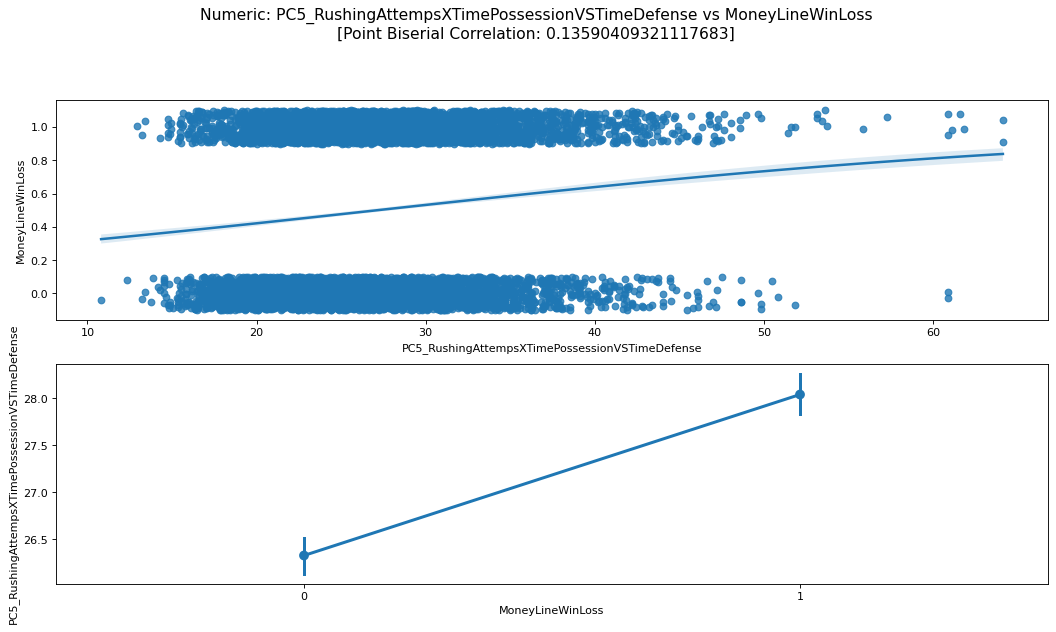

In [122]:
plotting.numeric_binary_bivariate(df_eda, 'PC5_RushingAttempsXTimePossessionVSTimeDefense', 'MoneyLineWinLoss')

Small positive correlation, not meaningful.

### Bivariate Analysis Summary
There are no main takeaways about interaction between features and the target value. There is some interesting inter-feature correlation:
- PointSpread & OffensiveTouchdowns (-0.57)
- PassingTouchdowns & OffensiveTouchdowns (0.62)

These alone are not very informative. It is clear that the data has minimal linear seperability and it is suprissing a logistic regression model can fair so well on this data alone.